# Label and Feature Distribution Smoothing for Deep Imbalanced Regression 

## Initial imports

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.optim import SGD, lr_scheduler

from pytorch_widedeep import Trainer
from pytorch_widedeep.preprocessing import TabPreprocessor
from pytorch_widedeep.models import TabMlp, WideDeep
from sklearn.metrics import mean_squared_error
from pytorch_widedeep.initializers import XavierNormal
from pytorch_widedeep.datasets import load_california_housing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from pytorch_widedeep.training._wd_dataset import WideDeepDataset
from torch.utils.data.dataloader import DataLoader

import matplotlib.pyplot as plt
from scipy.ndimage import convolve1d
from scipy.ndimage import gaussian_filter1d
from scipy.signal.windows import triang
from pytorch_widedeep.utils.deeptabular_utils import get_kernel_window, find_bin
from pytorch_widedeep.models import fds_layer

# increase displayed columns in jupyter notebook
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 300)

2022-01-16 20:43:53.485120: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-16 20:43:53.485200: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/palo/miniconda3/lib/python3.8/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


# Load dataset

In [2]:
df = load_california_housing(as_frame=True)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


# Effects of ks and sigma paramaters on kernel function

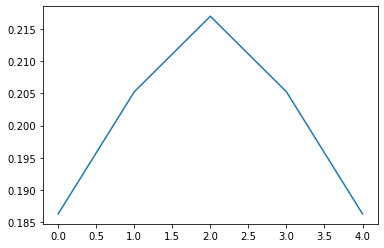

In [3]:
ks = 5
sigma = 2
half_ks = (ks - 1) // 2
base_kernel = [0.0] * half_ks + [1.0] + [0.0] * half_ks
kernel_window = gaussian_filter1d(base_kernel, sigma=sigma)
plt.plot(kernel_window)

# Label Distribution Smoothing - visualization
* visualization of  pytorch_widedeep.training._wd_dataset.WideDeepDataset._prepare_weights(...)

**Assign weight to each sample by following procedure:**
1. creating histogram from label values with nuber of bins = granularity
2.[OPTIONAL] reweighting label frequencies by sqrt
3.[OPTIONAL] smoothing label frequencies by convolution of kernel function window with frequencies list
4. inverting values by n_samples / (n_classes * np.bincount(y)), [see](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_sample_weight.html)
5. assigning weight to each sample from closest bin value 

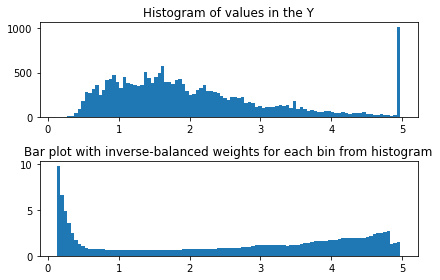

In [4]:
lds = True
kernel = "gaussian"
ks = 5
sigma = 2
reweight = "sqrt"
Y = df["MedHouseVal"].values
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
lds_Ymin = Y.min()
lds_Ymax = Y.max()
granularity = 100

bin_edges = np.linspace(lds_Ymin, lds_Ymax, num=granularity, endpoint=True)
labels = Y
value_dict = dict(zip(bin_edges[:-1], np.histogram(labels, bin_edges)[0]))
ax1.bar(
    value_dict.keys(),
    value_dict.values(),
    width=list(value_dict.keys())[1] - list(value_dict.keys())[0],
)
ax1.set_title("Histogram of values in the Y")

if reweight == "sqrt":
    value_dict = dict(zip(value_dict.keys(), np.sqrt(list(value_dict.values()))))

if kernel:
    lds_kernel_window = get_kernel_window(kernel, ks, sigma)
    smoothed_values = convolve1d(
        list(value_dict.values()), weights=lds_kernel_window, mode="constant"
    )

    weigths = sum(smoothed_values) / (len(smoothed_values) * smoothed_values)
    value_dict = dict(zip(value_dict.keys(), weigths))
else:
    values = list(value_dict.values())
    weigths = sum(values) / (len(values) * values)
    value_dict = dict(zip(value_dict.keys(), weigths))

ax2.bar(
    value_dict.keys(),
    value_dict.values(),
    width=list(value_dict.keys())[1] - list(value_dict.keys())[0],
)
ax2.set_title("Bar plot with inverse-balanced weights for each bin from histogram")
fig.tight_layout()

left_bin_edges = find_bin(bin_edges, labels)
weights = [value_dict[edge] for edge in left_bin_edges]

# Feature Distribution Smoothing
We use dataset feature values in this example, but during the training process features tensors are the ouput of last layer before FDS layer.
* labels are np.vstack-ed to reflect normal training scenario

In [5]:
features = torch.tensor(df.drop(columns=["MedHouseVal"]).values)
labels = torch.tensor(np.vstack(df["MedHouseVal"].values))
FDS = fds_layer.FDS(feature_dim=features.size(1))

In [6]:
for epoch in range(3):
    FDS.update_last_epoch_stats(epoch)
    FDS.update_running_stats(torch.clone(features).detach(), labels, epoch)

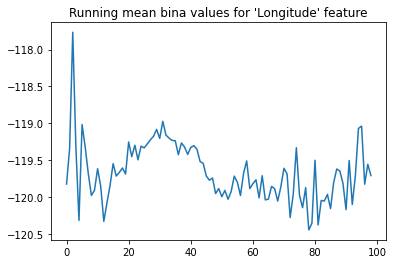

In [7]:
pd.DataFrame(FDS.running_mean_last_epoch.numpy()).iloc[:, 7].plot(
    title="Running mean bina values for 'Longitude' feature"
);

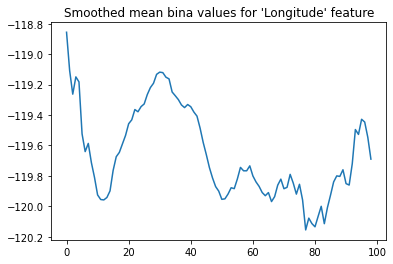

In [8]:
pd.DataFrame(FDS.smoothed_mean_last_epoch.numpy()).iloc[:, 7].plot(
    title="Smoothed mean bina values for 'Longitude' feature"
);

In [9]:
smoothed_features = FDS.smooth(torch.clone(features).detach(), labels, epoch).numpy()
left_bin_edges_indices = find_bin(
    FDS.bin_edges, labels.squeeze(), ret_value=False
).numpy()
continuous_cols = df.drop(columns=["MedHouseVal"]).columns.values.tolist()

df_w_bins = df.copy()
df_w_bins["MedHouseVal_bins"] = left_bin_edges_indices
df_smoothed_w_bins = df_w_bins.copy()
df_smoothed_w_bins[continuous_cols] = smoothed_features

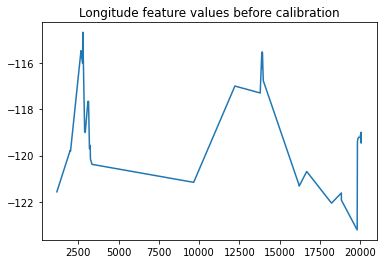

In [10]:
df_w_bins[df_w_bins["MedHouseVal_bins"] == 5]["Longitude"].plot(
    title="Longitude feature values before calibration"
);

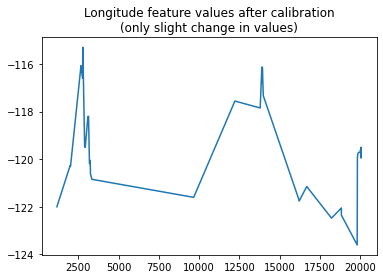

In [11]:
df_smoothed_w_bins[df_w_bins["MedHouseVal_bins"] == 5]["Longitude"].plot(
    title="Longitude feature values after calibration\n(only slight change in values)"
);

# Data preparation

In [12]:
df_train, df_valid = train_test_split(df, test_size=0.2, random_state=1)
df_valid, df_test = train_test_split(df_valid, test_size=0.5, random_state=1)

In [13]:
continuous_cols = df.drop(columns=["MedHouseVal"]).columns.values.tolist()

# Model with LDS & FDS

In [14]:
# deeptabular
tab_preprocessor = TabPreprocessor(continuous_cols=continuous_cols, scale=True)
X_tab_train = tab_preprocessor.fit_transform(df_train)
X_tab_valid = tab_preprocessor.transform(df_valid)
X_tab_test = tab_preprocessor.transform(df_test)

# target
y_train = df_train["MedHouseVal"].values
y_valid = df_valid["MedHouseVal"].values
y_test = df_test["MedHouseVal"].values

X_train = {"X_tab": X_tab_train, "target": y_train, "lds": True, "lds_reweight": "sqrt"}
X_val = {"X_tab": X_tab_valid, "target": y_valid}

In [15]:
deeptabular = TabMlp(
    column_idx=tab_preprocessor.column_idx,
    continuous_cols=tab_preprocessor.continuous_cols,
)
model = WideDeep(deeptabular=deeptabular, fds=True)
model

WideDeep(
  (deeptabular): TabMlp(
    (cat_and_cont_embed): DiffSizeCatAndContEmbeddings(
      (cont_norm): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (tab_mlp): MLP(
      (mlp): Sequential(
        (dense_layer_0): Sequential(
          (0): Dropout(p=0.1, inplace=False)
          (1): Linear(in_features=8, out_features=200, bias=True)
          (2): ReLU(inplace=True)
        )
        (dense_layer_1): Sequential(
          (0): Dropout(p=0.1, inplace=False)
          (1): Linear(in_features=200, out_features=100, bias=True)
          (2): ReLU(inplace=True)
        )
      )
    )
  )
  (FDS): FDS()
  (FDS_dropout): Dropout(p=0.1, inplace=False)
  (pred_layer): Linear(in_features=100, out_features=1, bias=True)
)

In [16]:
# Optimizers
deep_opt = SGD(model.deeptabular.parameters(), lr=0.1)
# LR Scheduler
deep_sch = lr_scheduler.StepLR(deep_opt, step_size=3)
# Hyperparameters
trainer = Trainer(
    model,
    objective="huber",
    lr_schedulers={"deeptabular": deep_sch},
    initializers={
        "deeptabular": XavierNormal,
        "FDS": XavierNormal,
        "FDS_dropout": XavierNormal,
        "pred_layer": XavierNormal,
    },
    optimizers={"deeptabular": deep_opt},
    metrics=[],
)

trainer.fit(X_train=X_train, X_val=X_val, n_epochs=5, batch_size=50)

print(
    f"test RMSE: {mean_squared_error(y_test, trainer.predict(X_tab=X_tab_test), squared=False)}"
)

predict: 100%|██████████| 42/42 [00:00<00:00, 118.68it/s]


test RMSE: 2.1421520310627966


# Model with LDS only

In [17]:
deeptabular = TabMlp(
    column_idx=tab_preprocessor.column_idx,
    continuous_cols=tab_preprocessor.continuous_cols,
)
model = WideDeep(deeptabular=deeptabular, fds=False)

# Optimizers
deep_opt = SGD(model.deeptabular.parameters(), lr=0.1)
# LR Scheduler
deep_sch = lr_scheduler.StepLR(deep_opt, step_size=3)
# Hyperparameters
trainer = Trainer(
    model,
    objective="huber",
    lr_schedulers={"deeptabular": deep_sch},
    initializers={"deeptabular": XavierNormal},
    optimizers={"deeptabular": deep_opt},
    metrics=[],
)

trainer.fit(X_train=X_train, X_val=X_val, n_epochs=5, batch_size=50)

print(
    f"test RMSE: {mean_squared_error(y_test, trainer.predict(X_tab=X_tab_test), squared=False)}"
)

predict: 100%|██████████| 42/42 [00:00<00:00, 112.46it/s]


test RMSE: 0.6921908298270133


# Model without FDS or LDS

In [18]:
# deeptabular
tab_preprocessor = TabPreprocessor(continuous_cols=continuous_cols, scale=True)
X_tab_train = tab_preprocessor.fit_transform(df_train)
X_tab_valid = tab_preprocessor.transform(df_valid)
X_tab_test = tab_preprocessor.transform(df_test)

# target
y_train = df_train["MedHouseVal"].values
y_valid = df_valid["MedHouseVal"].values
y_test = df_test["MedHouseVal"].values

X_train = {"X_tab": X_tab_train, "target": y_train}
X_val = {"X_tab": X_tab_valid, "target": y_valid}

deeptabular = TabMlp(
    column_idx=tab_preprocessor.column_idx,
    continuous_cols=tab_preprocessor.continuous_cols,
)
model = WideDeep(deeptabular=deeptabular, fds=False)

# Optimizers
deep_opt = SGD(model.deeptabular.parameters(), lr=0.1)
# LR Scheduler
deep_sch = lr_scheduler.StepLR(deep_opt, step_size=3)
# Hyperparameters
trainer = Trainer(
    model,
    objective="huber",
    lr_schedulers={"deeptabular": deep_sch},
    initializers={"deeptabular": XavierNormal},
    optimizers={"deeptabular": deep_opt},
    metrics=[],
)

trainer.fit(X_train=X_train, X_val=X_val, n_epochs=5, batch_size=50)

print(
    f"test RMSE: {mean_squared_error(y_test, trainer.predict(X_tab=X_tab_test), squared=False)}"
)

predict: 100%|██████████| 42/42 [00:00<00:00, 172.91it/s]

test RMSE: 0.6887689192708166
